<a href="https://colab.research.google.com/github/rpdahxn/MakeYourFirstGANWithPyTorch/blob/main/05_gan_simple_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

In [7]:
# function to generate real data

def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])
    return real_data

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # 손실함수 생성
        self.loss_function = nn.MSELoss()

        # SGD 옵티마이저 생성
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 신경망 출력 계산
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [8]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [10]:
# 판별기 테스트

D = Discriminator()

for i in range(10000):
    # 실제 데이터
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # 생성된 데이터
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


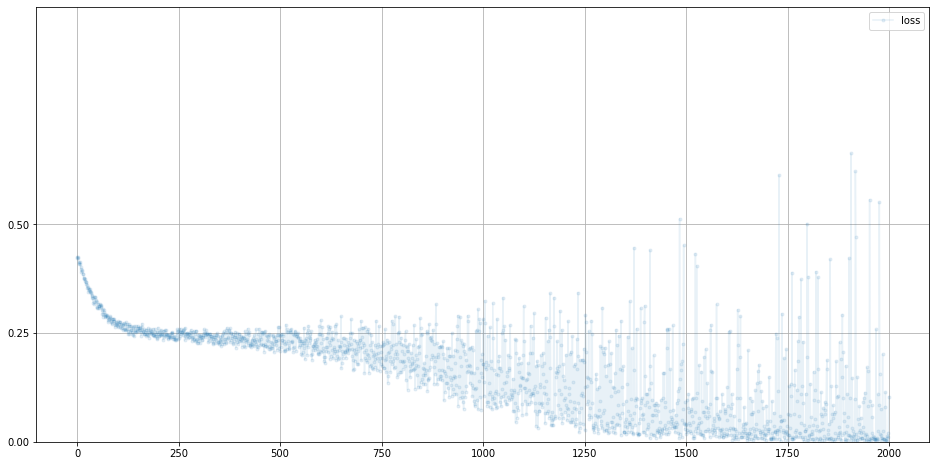

In [11]:
D.plot_progress()

In [12]:
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.8207736015319824
0.09561692178249359


In [13]:
class Generator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(  # 판별기의 반대순서로
            nn.Linear(1, 3),  
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )
        
        # SGD 옵티마이저 생성
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs)

        # 판별기로 전달
        d_output = D.forward(g_output)        

        loss = D.loss_function(d_output, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [14]:
G = Generator()

G.forward(torch.FloatTensor([0.5]))

tensor([0.4977, 0.3448, 0.5015, 0.5014], grad_fn=<SigmoidBackward0>)

원했던 대로 4개의 값을 출력한다.  
  
**GAN 훈련**

In [16]:
%%time 

# 판별기 및 생성기 생성

D = Discriminator()
G = Generator()

image_list = []

# 판별기와 생성기 훈련

for i in range(10000):
    
    # 참일 경우 판별기 훈련
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # 매 1000 회마다 이미지 추가
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
counter =  10000
CPU times: user 16.2 s, sys: 35.4 ms, total: 16.2 s
Wall time: 16.4 s


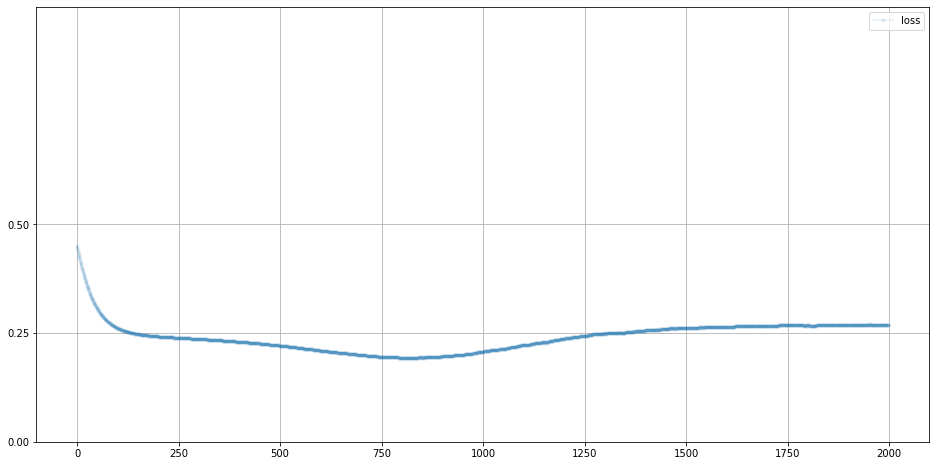

In [17]:
D.plot_progress()

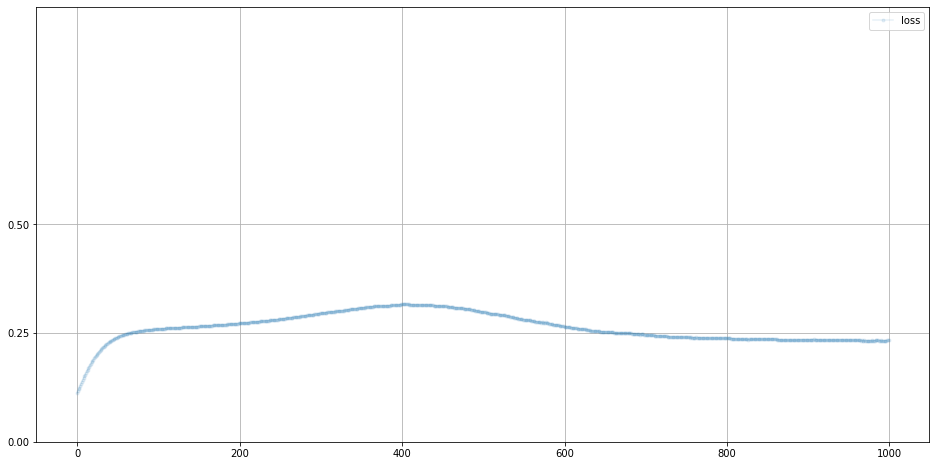

In [18]:
G.plot_progress()

In [19]:
# 직접 생성기를 구동해 출력 확인
G.forward(torch.FloatTensor([0.5]))

tensor([0.8957, 0.0317, 0.9443, 0.0431], grad_fn=<SigmoidBackward0>)

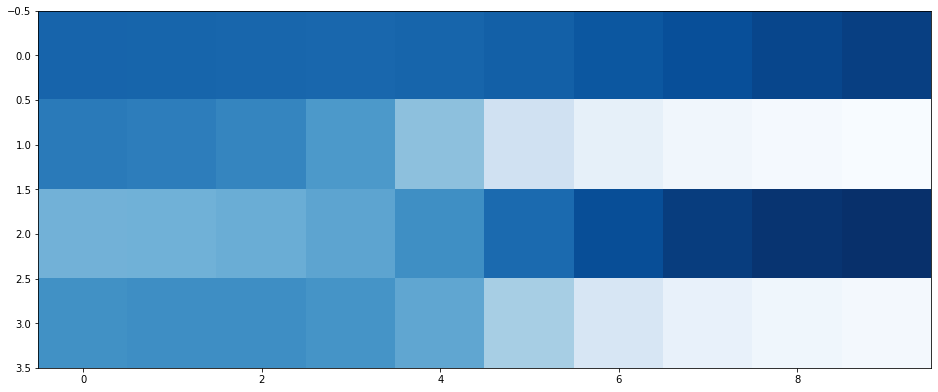

In [20]:
# 훈련시 패턴 시각화

plt.figure(figsize = (16, 8))

plt.imshow(numpy.array(image_list).T, interpolation = 'none', cmap = 'Blues')